# Unsupervised Learning, pt. 2

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import mglearn

from IPython.display import display

%matplotlib inline

# Днес

* Ще продължим заигравката с unsupervised learning
* Ще разгледаме един dataset (labelled faces in the wild) през unsupervised learning алгоритми
* Вероятно ще приключим по-рано

# Задачи до момента

1. Изберете dataset и направете data exploration
2. Опитайте да направите по-добри резултати от нас на Titanic
3. Опитайте да направите по-добри резултати от нас на Spooky Author Identification

Plot twist: deadline 27 ноември (понеделник)

Формат: repository в GitHub с три notebook-а.

# Labelled faces in the wild

Този dataset съдържа снимки на разни хора, label-нати с имената им.

Има го в `sklearn.datasets`.

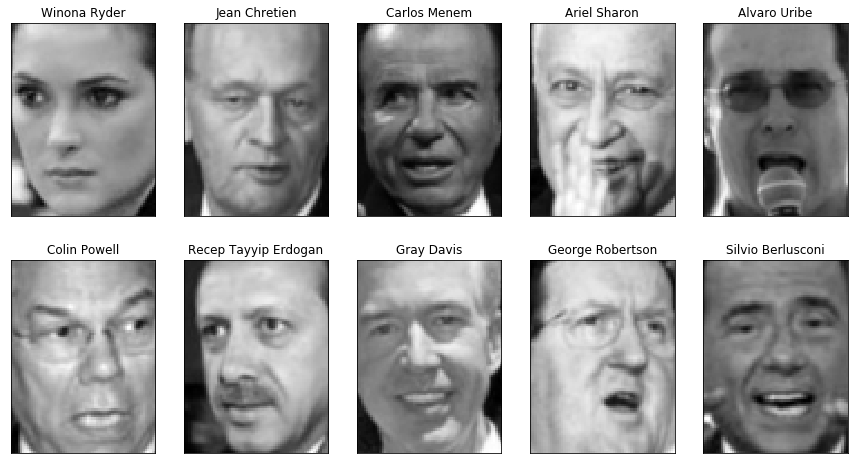

In [2]:
from sklearn.datasets import fetch_lfw_people

people = fetch_lfw_people(min_faces_per_person=20, resize=0.7)

image_shape = people.images[0].shape
fix, axes = plt.subplots(2, 5, figsize=(15, 8), subplot_kw={'xticks': (), 'yticks': ()})

for target, image, ax in zip(people.target, people.images, axes.ravel()):
    ax.imshow(image, cmap='gray')
    ax.set_title(people.target_names[target])

`people.images` съдържа тензор с картинки, докато в `people.data` картинката е представена като ред в матрица.

In [3]:
print("people.images.shape: {}".format(people.images.shape))
print("people.data.shape:   {}".format(people.data.shape))
print("people.target.shape: {}".format(people.target.shape))
print("People:              {}".format(len(people.target_names)))

people.images.shape: (3023, 87, 65)
people.data.shape:   (3023, 5655)
people.target.shape: (3023,)
People:              62


`people.target` съдържа класовете, докато `people.target_names` съпоставя класовете на истински имена.

In [4]:
people.target

array([61, 25,  9, ..., 14, 15, 14])

In [5]:
people.target_names

array(['Alejandro Toledo', 'Alvaro Uribe', 'Amelie Mauresmo',
       'Andre Agassi', 'Angelina Jolie', 'Ariel Sharon',
       'Arnold Schwarzenegger', 'Atal Bihari Vajpayee', 'Bill Clinton',
       'Carlos Menem', 'Colin Powell', 'David Beckham', 'Donald Rumsfeld',
       'George Robertson', 'George W Bush', 'Gerhard Schroeder',
       'Gloria Macapagal Arroyo', 'Gray Davis', 'Guillermo Coria',
       'Hamid Karzai', 'Hans Blix', 'Hugo Chavez', 'Igor Ivanov',
       'Jack Straw', 'Jacques Chirac', 'Jean Chretien', 'Jennifer Aniston',
       'Jennifer Capriati', 'Jennifer Lopez', 'Jeremy Greenstock',
       'Jiang Zemin', 'John Ashcroft', 'John Negroponte',
       'Jose Maria Aznar', 'Juan Carlos Ferrero', 'Junichiro Koizumi',
       'Kofi Annan', 'Laura Bush', 'Lindsay Davenport', 'Lleyton Hewitt',
       'Luiz Inacio Lula da Silva', 'Mahmoud Abbas',
       'Megawati Sukarnoputri', 'Michael Bloomberg', 'Naomi Watts',
       'Nestor Kirchner', 'Paul Bremer', 'Pete Sampras',
       'Rece

Как ли изглеждат данните?

In [6]:
pd.Series(people.target_names[people.target]).value_counts().head(10)

George W Bush        530
Colin Powell         236
Tony Blair           144
Donald Rumsfeld      121
Gerhard Schroeder    109
Ariel Sharon          77
Hugo Chavez           71
Junichiro Koizumi     60
Jean Chretien         55
John Ashcroft         53
dtype: int64

George Bush и Colin Powell са доста overrepresented. Ще се опитаме да намалим снимките до най-много 50 на човек.

Този код може да свърши тази работа:

In [7]:
mask = np.zeros(people.target.shape, dtype=np.bool)
for target in np.unique(people.target):
    mask[np.where(people.target == target)[0][:50]] = 1

Нека го разпакетираме.

`np.zeros` създава матрица от нули. Ако типа е `np.bool`, ще е матрица от `False`:

In [8]:
np.zeros((10,), dtype=np.bool)

array([False, False, False, False, False, False, False, False, False, False], dtype=bool)

`==` на np масив със скалар прави векторизирано сравнение.

In [9]:
np.array([1, 2, 1, 2]) == 2

array([False,  True, False,  True], dtype=bool)

`np.where` приема булев масив и връща индексите на `True`-тата.

In [10]:
np.where(np.array([1, 2, 1, 2]) == 2)

(array([1, 3]),)

Забележете, че резултате е tuple.

Присвояването на индекс с масив работи както очаквате:

In [11]:
things = np.zeros((10,), dtype=np.bool)
things[np.array([1, 3, 5])] = 1
things

array([False,  True, False,  True, False,  True, False, False, False, False], dtype=bool)

In [12]:
mask = np.zeros(people.target.shape, dtype=np.bool)
for target in np.unique(people.target):
    mask[np.where(people.target == target)[0][:50]] = 1

Свеждаме резултата само до картинките в маската:

In [13]:
X = people.data[mask]
y = people.target[mask]

Също, ще направим poor man's scaling:

In [14]:
print(np.min(X), np.max(X))

0.0 255.0


In [15]:
X = people.data[mask] / 255.

In [16]:
print(np.min(X), np.max(X))

0.0 1.0


Да погледнем дали резултатите са както очакваме:

In [17]:
pd.Series(people.target_names[y]).value_counts().head(15)

Jacques Chirac               50
Jean Chretien                50
George W Bush                50
Hugo Chavez                  50
Junichiro Koizumi            50
John Ashcroft                50
Tony Blair                   50
Donald Rumsfeld              50
Colin Powell                 50
Ariel Sharon                 50
Gerhard Schroeder            50
Serena Williams              50
Vladimir Putin               49
Luiz Inacio Lula da Silva    48
Gloria Macapagal Arroyo      44
dtype: int64

In [18]:
print("X.shape: {}".format(X.shape))
print("y.shape: {}".format(y.shape))

X.shape: (2063, 5655)
y.shape: (2063,)


# Класификация

Да се пробваме да направим много прост класификатор.

Нека си разделим тренировъчни и тестови данни:

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

Първо, нека видим как ще се справи един наивен kNN:

In [20]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
knn.score(X_test, y_test)

0.2558139534883721

Нека да пробваме да преработим данните му през `PCA`:

In [21]:
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(
    PCA(n_components=100, whiten=True, random_state=0),
    KNeighborsClassifier(n_neighbors=1)
)
pipeline.fit(X_train, y_train)
pipeline.score(X_test, y_test)

0.31395348837209303

Имаме малко подобрение! Това може да се очаква с kNN, защото PCA практически намалява шума.

Образно казано.

# Principal Component Analysis

Как изглеждат данните, които се подават на kNN?

In [22]:
print("X.shape:             {}".format(X_test.shape))
print("Transformed X.shape: {}".format(pipeline.steps[0][1].transform(X_test).shape))

X.shape:             (516, 5655)
Transformed X.shape: (516, 100)


Всяка картинка е сведена до вектор от 100 числа.

Какво ли е научил `PCA`?:

In [23]:
pca = pipeline.steps[0][1]
pca.components_

array([[-0.00289469, -0.00345396, -0.00398728, ..., -0.00546063,
        -0.00466693, -0.0037386 ],
       [ 0.01129335,  0.01116703,  0.01178321, ..., -0.02247014,
        -0.02143693, -0.02021578],
       [ 0.03042047,  0.03140382,  0.03268783, ...,  0.00427228,
         0.00381443,  0.0033669 ],
       ..., 
       [ 0.00716479, -0.00541259, -0.00257968, ...,  0.04397098,
         0.04515025,  0.05164386],
       [-0.01927833, -0.03050758, -0.03367972, ...,  0.00854935,
         0.0038387 , -0.00141849],
       [ 0.02400533,  0.01745486,  0.00657826, ...,  0.02086895,
        -0.00867515, -0.05492262]], dtype=float32)

In [24]:
pca.components_.shape

(100, 5655)

Изглежда алгоритъма е научил 100 вектора, всеки от които с 5655 компонента – броя пиксели във всяка картинка. Какво ли ще стане ако визуализираме тези вектори?

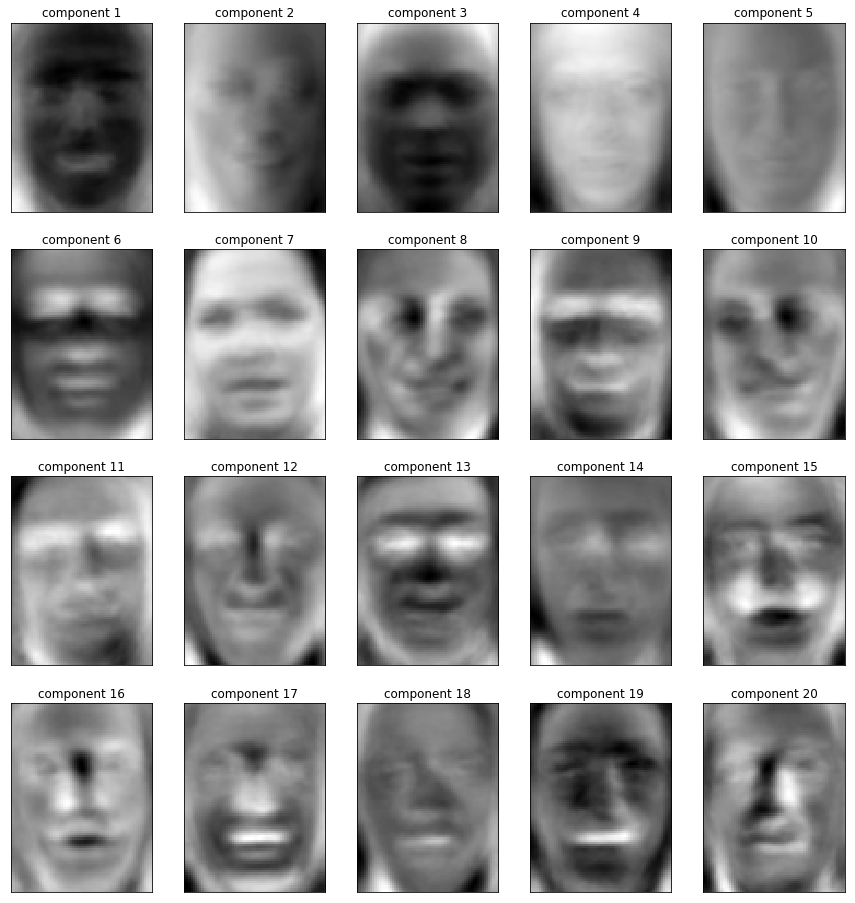

In [25]:
fix, axes = plt.subplots(4, 5, figsize=(15, 16), subplot_kw={'xticks': (), 'yticks': ()})

for i, (component, ax) in enumerate(zip(pca.components_, axes.ravel())):
    ax.imshow(component.reshape(image_shape), cmap='gray')
    ax.set_title("component {}".format((i + 1)))

Тези картинки са компонентите, открити от PCA. Когато прекарате изображение през `pca.transform`, той го свежда до линейна комбинация на тези 100 компонента. 100те числа в резултата са коефициентите пред всеки от компонентите.

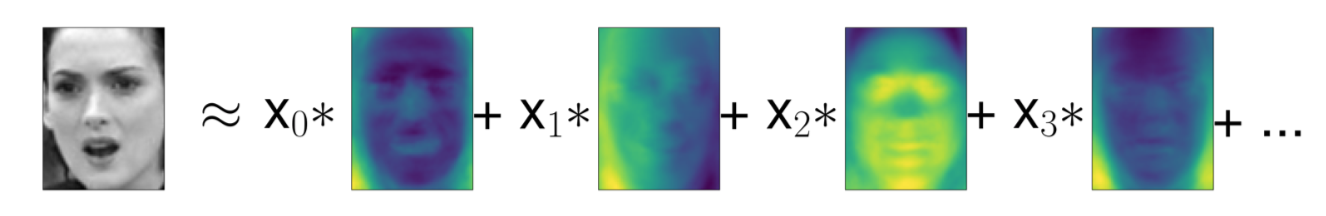

В такива случаи, компонентите често биват наричани eigenfaces.

In [26]:
X_test_pca = pca.transform(X_test)
print("X_test.shape:     {}".format(X_test.shape))
print("X_test_pca.shape: {}".format(X_test_pca.shape))

X_test.shape:     (516, 5655)
X_test_pca.shape: (516, 100)


`PCA` (и някои други) имат `inverse_transform`, която проектира трансформирания вектор в оригиналното пространство.

In [27]:
X_reformed = pca.inverse_transform(X_test_pca)
print("X_test.shape:     {}".format(X_test.shape))
print("X_test_pca.shape: {}".format(X_test_pca.shape))
print("X_reformed.shape: {}".format(X_reformed.shape))

X_test.shape:     (516, 5655)
X_test_pca.shape: (516, 100)
X_reformed.shape: (516, 5655)


Бихме могли да визуализираме резултата от `inverse_transform`, така че да го интерпретираме:

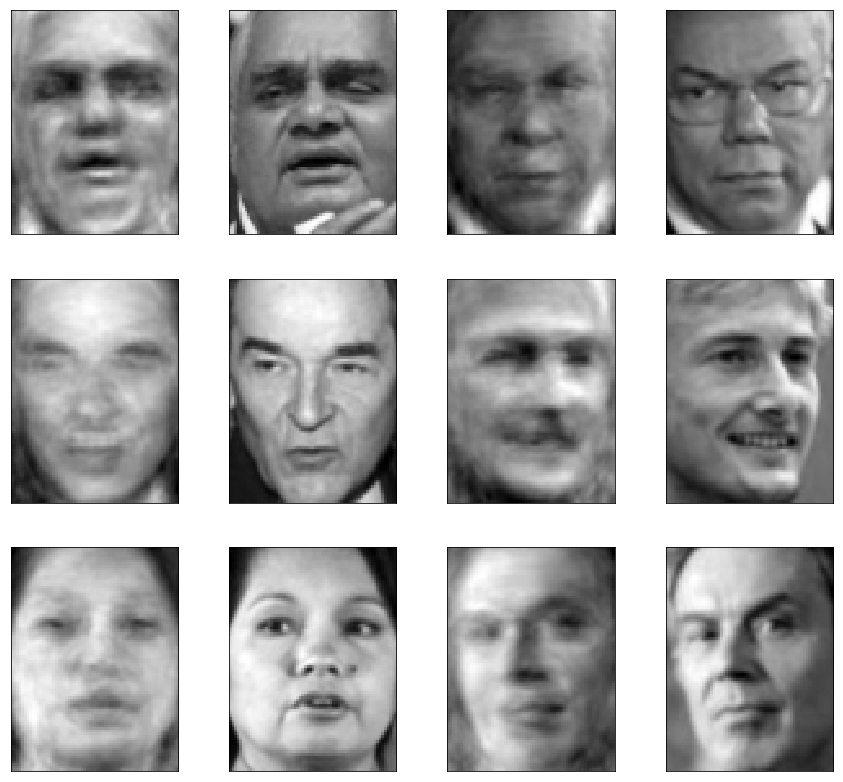

In [28]:
import itertools

fig, axes = plt.subplots(3, 4, figsize=(15, 14), subplot_kw={'xticks': (), 'yticks': ()})

for i, (picture, ax) in enumerate(zip(itertools.chain(*zip(X_reformed, X_test)), axes.ravel())):
    ax.imshow(picture.reshape(image_shape), cmap='gray')

Какво ли ще стане, ако ползваме повече компоненти? Нека си напишем функция, с която да пробваме.

In [29]:
def compression_with_pca(train, test, n_components):
    pca = PCA(n_components=n_components, whiten=True, random_state=0)
    pca.fit(train)
    reformed = pca.inverse_transform(pca.transform(test))
    
    fig, axes = plt.subplots(3, 4, figsize=(15, 14), subplot_kw={'xticks': (), 'yticks': ()})

    for i, (picture, ax) in enumerate(zip(itertools.chain(*zip(reformed, test)), axes.ravel())):
        ax.imshow(picture.reshape(image_shape), cmap='gray')

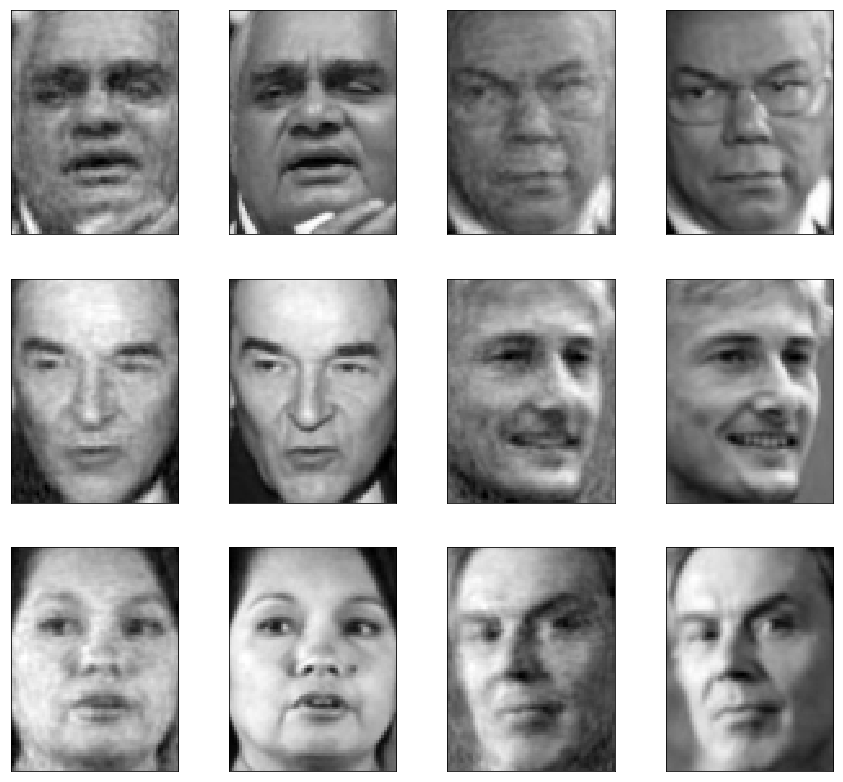

In [30]:
compression_with_pca(X_train, X_test, 500)

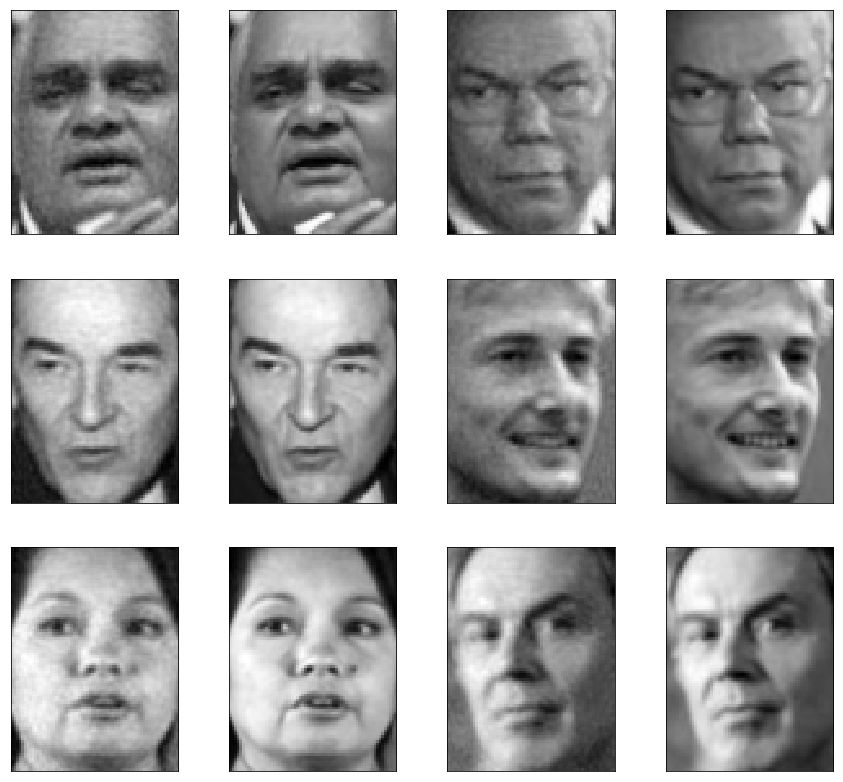

In [31]:
compression_with_pca(X_train, X_test, 1000)

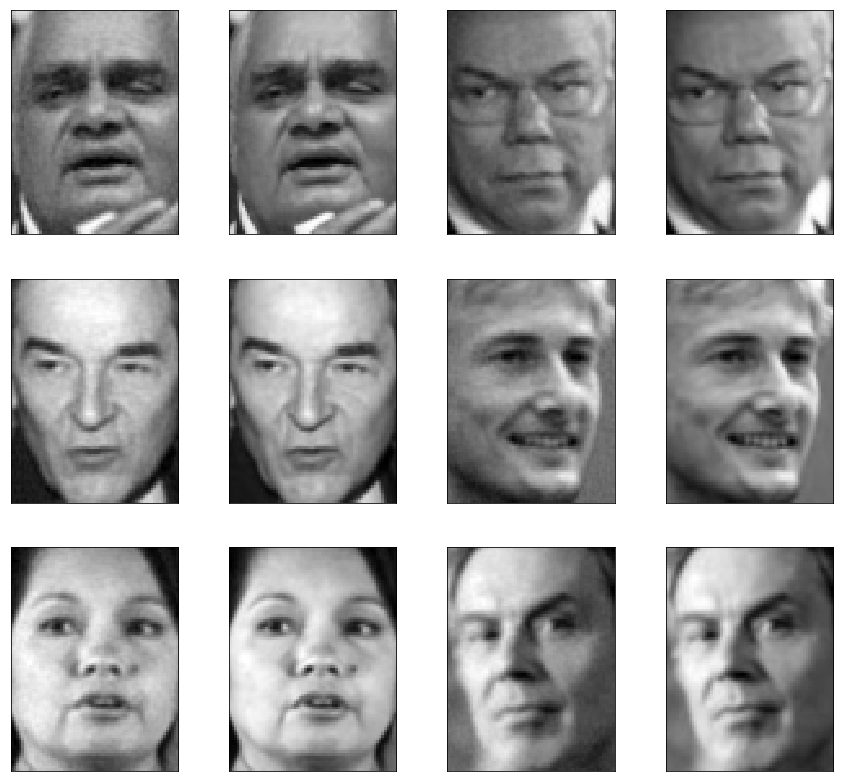

In [32]:
compression_with_pca(X_train, X_test, 2000)

# Non-Negative Matrix Factorization

Да видим Какво ще научи `NMF` в този dataset.

In [33]:
from sklearn.decomposition import NMF

nmf = NMF(n_components=15, random_state=1)
nmf.fit(X_train)

X_train_nmf = nmf.transform(X_train)
X_test_nmf  = nmf.transform(X_test)

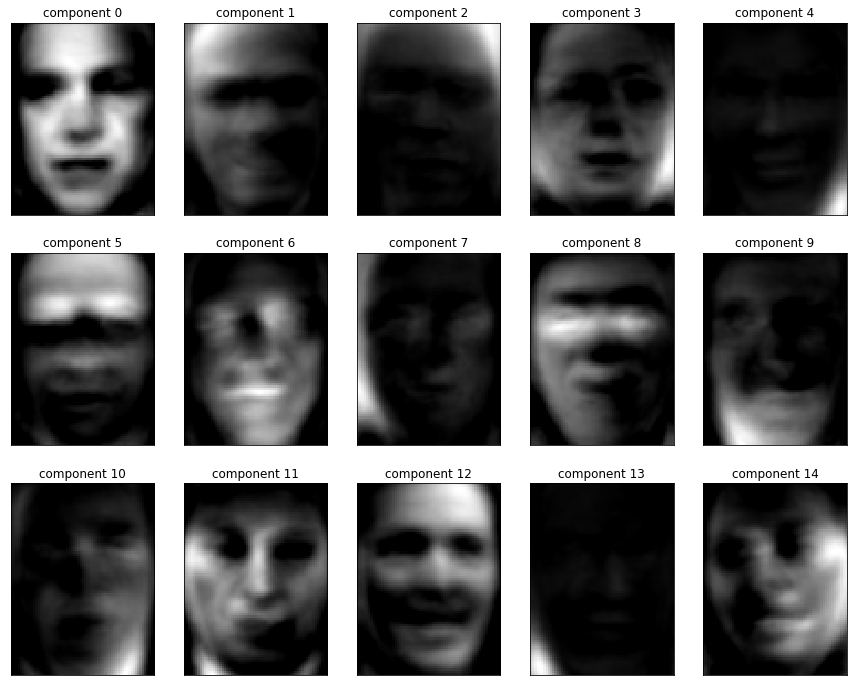

In [34]:
fix, axes = plt.subplots(3, 5, figsize=(15, 12), subplot_kw={'xticks': (), 'yticks': ()})
for i, (component, ax) in enumerate(zip(nmf.components_, axes.ravel())):
    ax.imshow(component.reshape(image_shape), cmap='gray')
    ax.set_title("component {}".format(i))

NMF търси "адитивни" компоненти, чиято сума може да изрази добре оригиналния dataset. Резултатите са по-лесни за интерпретация, понеже няма отрицателни стойности (за разлика от при PCA). Любопитно е да разгледаме какво са научили някои от компонентите.

За целта може да си напишем функция, която намира картинките, за които този компонент има най-висок коефициент.

In [35]:
def draw_closest(component, components, data):
    indices = np.argsort(data[:, component])[::-1]

    fig, axes = plt.subplots(2, 5, figsize=(15, 8), subplot_kw={'xticks': (), 'yticks': ()})
    axes[0][0].imshow(components[component].reshape(image_shape), cmap='gray')
    
    for i, (ind, ax) in enumerate(zip(indices, axes.ravel()[1:])):
        ax.imshow(X_train[ind].reshape(image_shape), cmap='gray')

Компонент 14 всякаш хваща лица, завъртяни наляво.

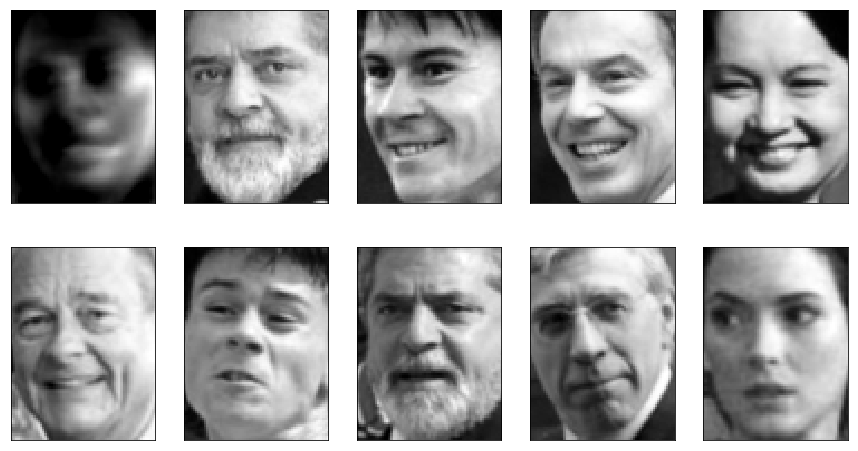

In [36]:
draw_closest(14, nmf.components_, X_train_nmf)

Компонент 12 е аналогичен, но в другата посока.

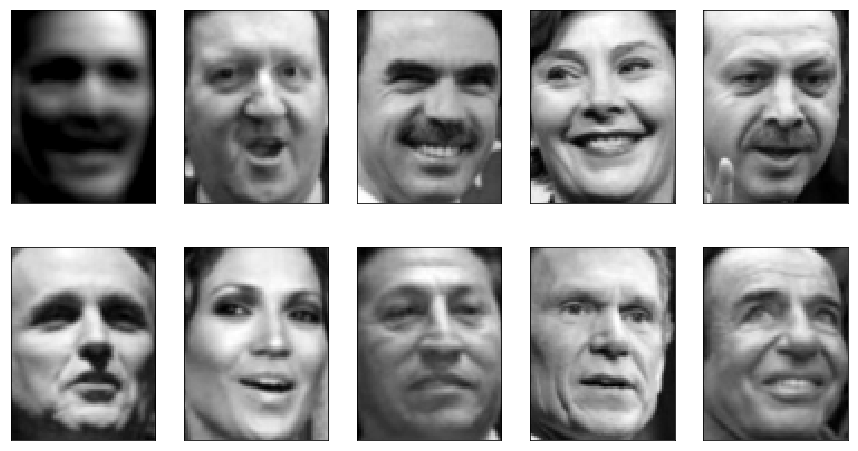

In [37]:
draw_closest(12, nmf.components_, X_train_nmf)

Компонент 2 хваща бели шапки или други светли региони около главата.

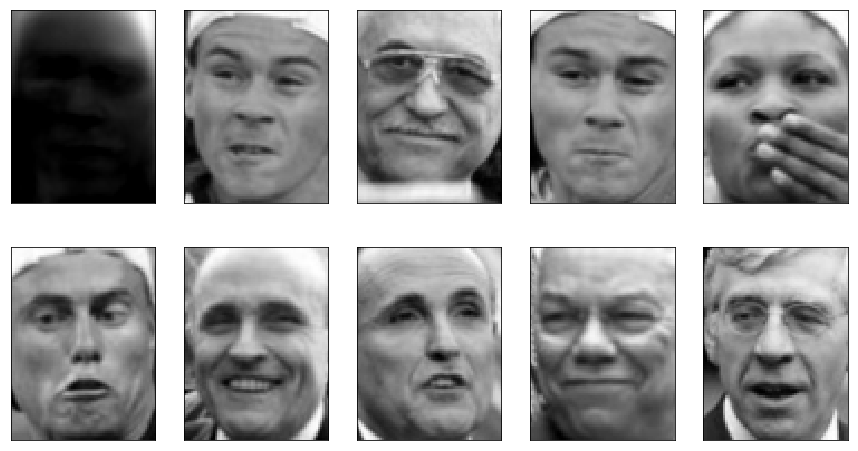

In [38]:
draw_closest(2, nmf.components_, X_train_nmf)

Компонент 4 изглежда да хваща яки отдясно.

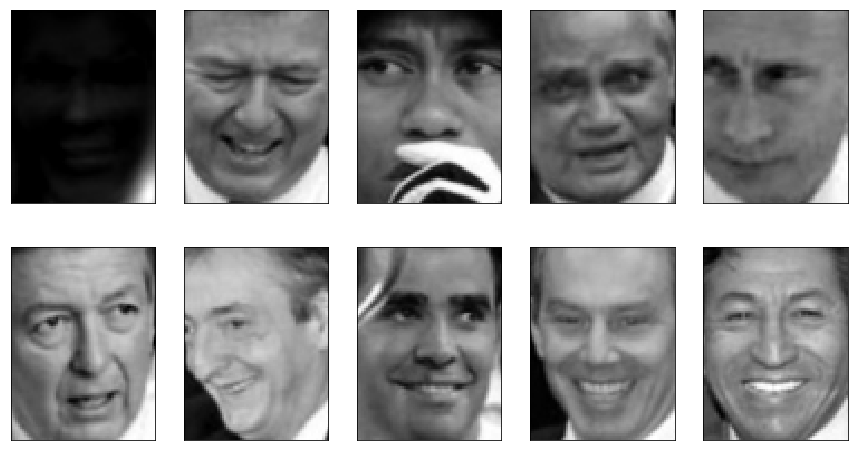

In [39]:
draw_closest(4, nmf.components_, X_train_nmf)

Компонент 13 е много сходен.

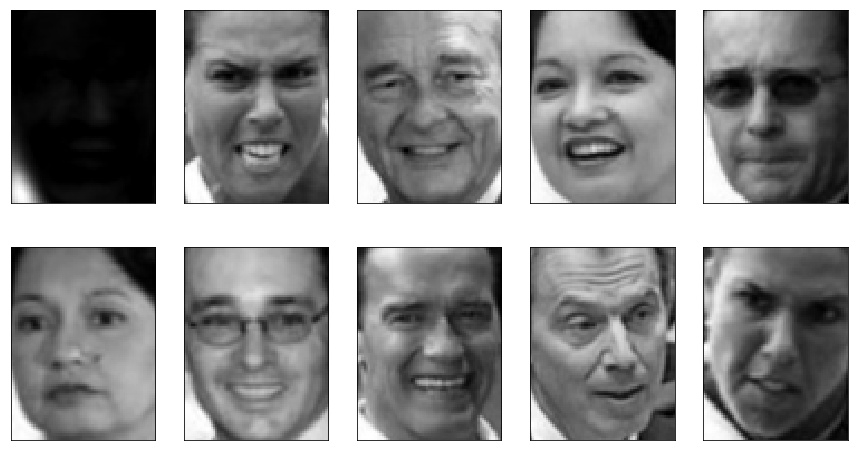

In [40]:
draw_closest(13, nmf.components_, X_train_nmf)

Бихме могли да видим и как изглежда компресията при NMF.

In [41]:
def compression_with_nmf(train, test, n_components):
    nmf = NMF(n_components=n_components, random_state=0)
    nmf.fit(train)
    reformed = nmf.inverse_transform(nmf.transform(test))
    
    fig, axes = plt.subplots(3, 4, figsize=(15, 14), subplot_kw={'xticks': (), 'yticks': ()})

    for i, (picture, ax) in enumerate(zip(itertools.chain(*zip(reformed, test)), axes.ravel())):
        ax.imshow(picture.reshape(image_shape), cmap='gray')

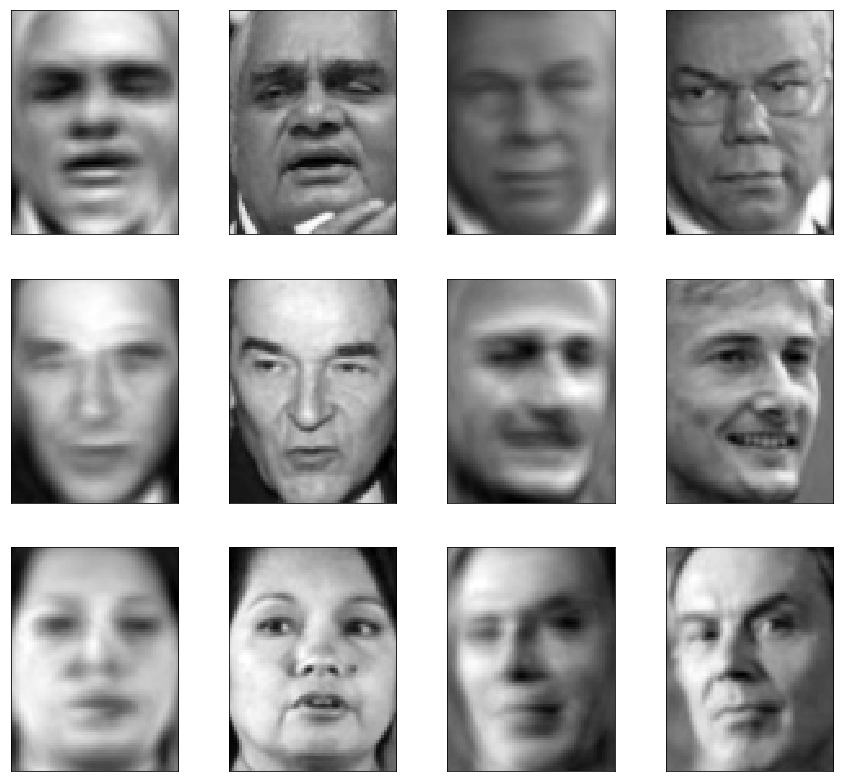

In [42]:
compression_with_nmf(X_train, X_test, 100)

# Класификация с Eigenfaces

Базирана на този пример.

http://scikit-learn.org/stable/auto_examples/applications/plot_face_recognition.html#sphx-glr-auto-examples-applications-plot-face-recognition-py

Ще ограничим dataset-а само до хора, които имат повече от 70 снимки.

In [43]:
people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

Данните изглеждат наред:

In [44]:
print("people.images.shape: {}".format(people.images.shape))
print("Number of people:    {}".format(len(people.target_names)))

people.images.shape: (1288, 50, 37)
Number of people:    7


Кои ли са хората?

In [45]:
pd.Series(people.target_names[people.target]).value_counts()

George W Bush        530
Colin Powell         236
Tony Blair           144
Donald Rumsfeld      121
Gerhard Schroeder    109
Ariel Sharon          77
Hugo Chavez           71
dtype: int64

Да си извлечем нужните данни:

In [46]:
X = people.data
y = people.target

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)

Нека тренираме модел (с предварително grid-search-нати хиперпараметри):

In [48]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('pca', PCA(n_components=150, whiten=True, random_state=42)),
    ('svc', SVC(C=10, gamma=0.0025, kernel='rbf', class_weight='balanced')),
])

pipeline.fit(X_train, y_train)
pipeline.score(X_test, y_test)

0.86645962732919257

Изглежда доста добре!

In [49]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred, target_names=people.target_names))
print(confusion_matrix(y_test, y_pred, labels=range(len(people.target_names))))

                   precision    recall  f1-score   support

     Ariel Sharon       0.81      0.89      0.85        19
     Colin Powell       0.84      0.95      0.89        59
  Donald Rumsfeld       0.90      0.63      0.75        30
    George W Bush       0.87      0.95      0.91       133
Gerhard Schroeder       0.91      0.74      0.82        27
      Hugo Chavez       0.92      0.61      0.73        18
       Tony Blair       0.88      0.83      0.86        36

      avg / total       0.87      0.87      0.86       322

[[ 17   1   0   1   0   0   0]
 [  2  56   0   0   0   1   0]
 [  1   1  19   6   1   0   2]
 [  0   7   0 126   0   0   0]
 [  1   0   1   5  20   0   0]
 [  0   2   0   2   1  11   2]
 [  0   0   1   5   0   0  30]]


Резултатите без PCA изглеждат много аналогично, стига да нацелите параметрите:

In [50]:
from sklearn.svm import SVC

pipeline = make_pipeline(
    MinMaxScaler(),
    SVC(kernel='rbf', class_weight='balanced', C=1000, gamma=0.00007)
)
pipeline.fit(X_train, y_train)
pipeline.score(X_test, y_test)

0.86645962732919257

In [51]:
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred, target_names=people.target_names))
print(confusion_matrix(y_test, y_pred, labels=range(len(people.target_names))))

                   precision    recall  f1-score   support

     Ariel Sharon       0.76      0.68      0.72        19
     Colin Powell       0.84      0.95      0.89        59
  Donald Rumsfeld       0.79      0.63      0.70        30
    George W Bush       0.91      0.94      0.93       133
Gerhard Schroeder       0.73      0.70      0.72        27
      Hugo Chavez       0.93      0.78      0.85        18
       Tony Blair       0.92      0.92      0.92        36

      avg / total       0.86      0.87      0.86       322

[[ 13   1   1   2   1   1   0]
 [  2  56   0   0   1   0   0]
 [  1   4  19   4   1   0   1]
 [  1   5   1 125   1   0   0]
 [  0   0   3   4  19   0   1]
 [  0   0   0   2   1  14   1]
 [  0   1   0   0   2   0  33]]


# Клъстеризация

Неща пробваме `DBSCAN` с различни стойности на `eps`:

In [52]:
from sklearn.cluster import DBSCAN

X_norm = X / 255.

for eps in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]:
    pipeline = make_pipeline(
        PCA(n_components=100, whiten=True, random_state=0),
        DBSCAN(eps=eps, min_samples=3)
    )
    labels = pipeline.fit_predict(X_norm)
    print("{:>3} | {}".format(eps, np.unique(labels)))
    print("{:>3} | {}".format(eps, np.bincount(labels + 1)))
    print("----------------------------------------------------------")

  1 | [-1]
  1 | [1288]
----------------------------------------------------------
  2 | [-1]
  2 | [1288]
----------------------------------------------------------
  3 | [-1]
  3 | [1288]
----------------------------------------------------------
  4 | [-1]
  4 | [1288]
----------------------------------------------------------
  5 | [-1]
  5 | [1288]
----------------------------------------------------------
  6 | [-1  0]
  6 | [1285    3]
----------------------------------------------------------
  7 | [-1  0  1  2  3  4  5  6]
  7 | [1251    3   15    4    4    3    5    3]
----------------------------------------------------------
  8 | [-1  0  1  2  3  4  5  6]
  8 | [1074  194    3    5    3    3    3    3]
----------------------------------------------------------
  9 | [-1  0  1  2  3  4  5  6]
  9 | [779 488   3   5   3   4   3   3]
----------------------------------------------------------
 10 | [-1  0]
 10 | [488 800]
-------------------------------------------------------

При `eps=7` има интересни резултати, които си струва да погледнем:

In [53]:
def show_clusters(labels, limit=100):
    rows, h, w = people.images.shape
    image_shape = (h, w)
    for cluster in range(max(labels) + 1):
        mask = labels == cluster
        n_images = min(limit, np.sum(mask))

        fig, axes = plt.subplots(1, n_images, figsize=(n_images * 1.5, 4), subplot_kw={'xticks': (), 'yticks': ()})
        for image, label, ax in zip(X[mask], y[mask], axes):
            ax.imshow(image.reshape(image_shape), cmap='gray')
            ax.set_title(people.target_names[label].split()[-1])

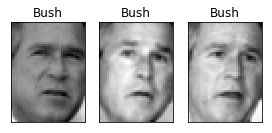

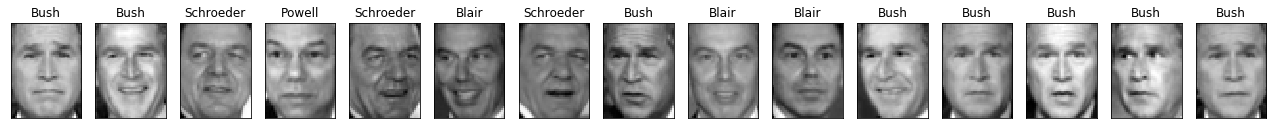

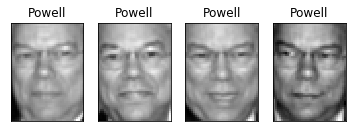

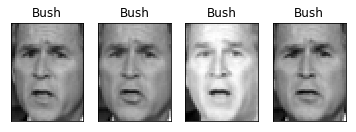

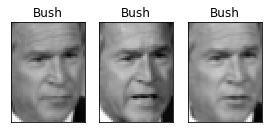

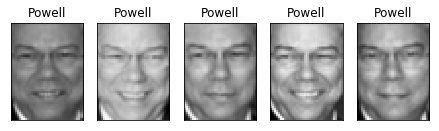

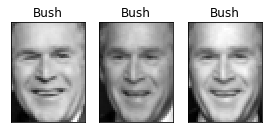

In [54]:
pipeline = make_pipeline(
    PCA(n_components=100, whiten=True, random_state=0),
    DBSCAN(eps=7, min_samples=3)
)
labels = pipeline.fit_predict(X_norm)
show_clusters(labels)

Намерило е някакви клъстери, ама не и такива, каквито ние искаме.

Как ли ще се справи KMeans?

In [71]:
from sklearn.cluster import KMeans

pipeline = make_pipeline(
    PCA(n_components=100, whiten=True, random_state=0),
    KMeans(n_clusters=200),
)
pipeline.fit(X_norm)
labels = pipeline.predict(X_norm)

In [67]:
np.bincount(labels)

array([ 50,  37, 254, 270, 566,  49,  62])

Това едва ли са правилните резултати – имаше клъстер с 530 картинки.

In [68]:
print("Expected: {}".format(sorted(np.bincount(y))))
print("Actual:   {}".format(sorted(np.bincount(labels))))

Expected: [71, 77, 109, 121, 144, 236, 530]
Actual:   [37, 49, 50, 62, 254, 270, 566]


Изглежда наистина да има голямо разминаване. Какво ли ще каже `adjusted_rand_score?`.

In [69]:
from sklearn.metrics import adjusted_rand_score

print(adjusted_rand_score(labels, y))

-0.00591538397861


TypeError: zip argument #3 must support iteration

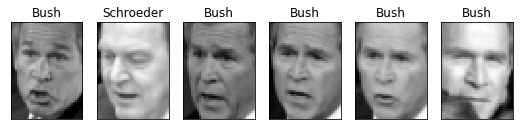

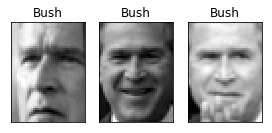

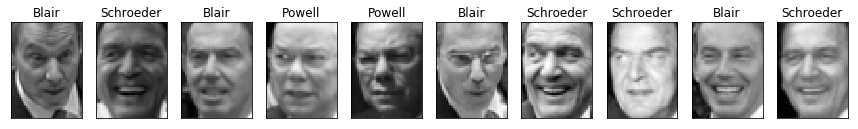

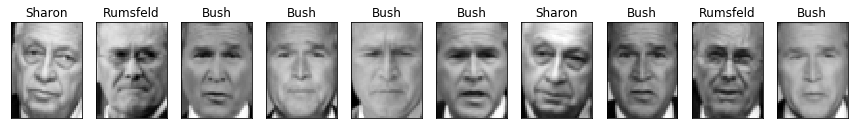

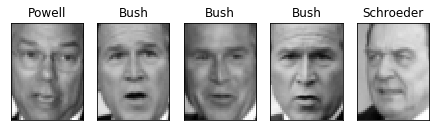

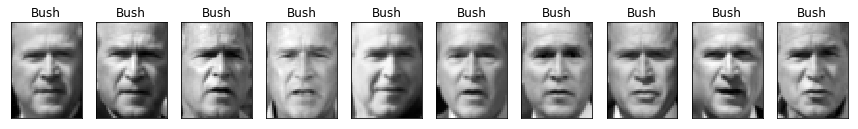

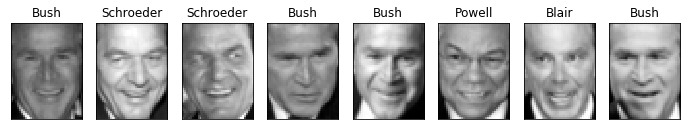

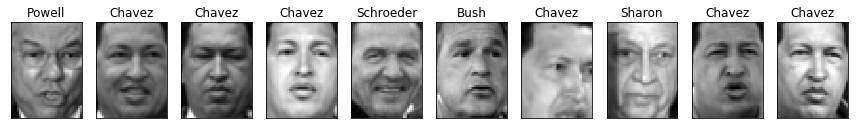

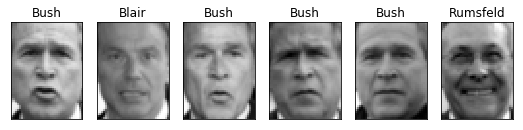

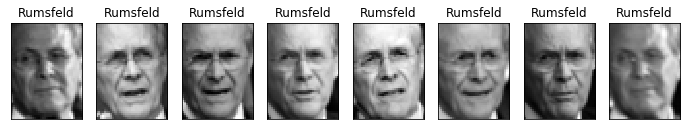

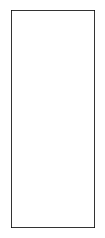

In [72]:
show_clusters(labels, limit=10)

In [73]:
from sklearn.cluster import AgglomerativeClustering
agglo = make_pipeline(
    PCA(n_components=100, whiten=True),
    AgglomerativeClustering(n_clusters=7),
)
labels = agglo.fit_predict(X_norm)

In [74]:
adjusted_rand_score(labels, y)

0.087401318455533936

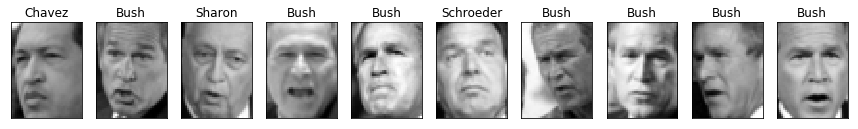

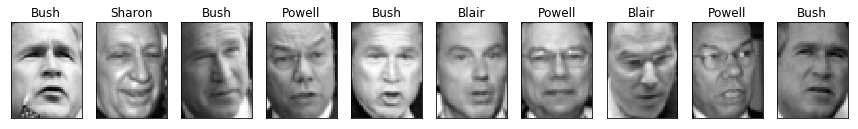

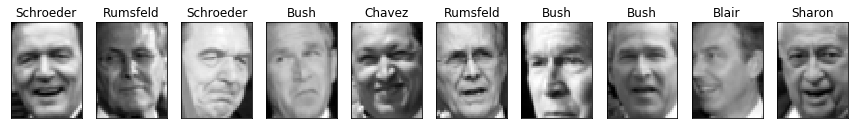

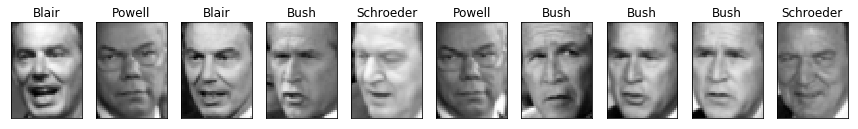

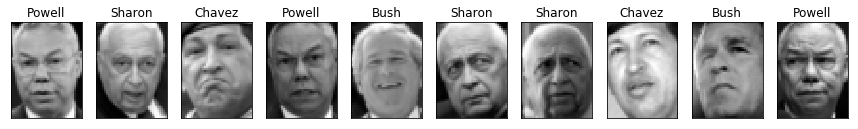

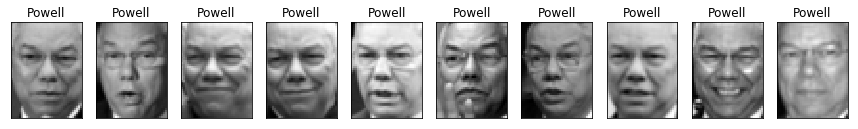

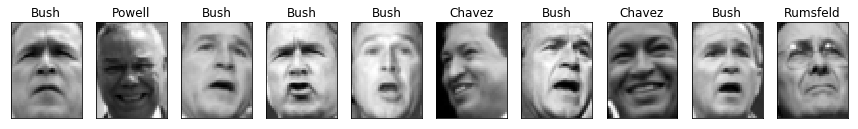

In [75]:
show_clusters(labels, limit=10)

# Latent Dirichlet Allocation

LDA е алгоритъм, който търси общи теми в корпуси от документи.

Ще пробваме да го приложим върху dataset от IMDB ревюта.

Dataset-а може да бъде изтеглен от тук:

http://ai.stanford.edu/~amaas/data/sentiment/

Ето така може да го заредим:

```python
from sklearn.datasets import load_files
reviews_train = load_files("/path/to/aclImdb/train/")
text_train, y_train = reviews_train.data, reviews_train.target
```

Ето така може да го прекараме през `LDA`:

```python
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_df=.15, max_features=10000)
X = vectorizer.fit_transform(text_train)

lda = LatentDirichletAllocation(n_components=10, learning_method="batch", max_iter=15, random_state=0)
topics = lda.fit_transform(X)
```

И ето още малко код, който ще визуализира най-популярните думи от темите:

```python
sorting = np.argsort(lda.components_, axis=1)[:, ::-1]
feature_names = np.array(vect.get_feature_names())
mglearn.tools.print_topics(topics=range(10), feature_names=feature_names, sorting=sorting, topics_per_chunk=5, n_words=10)
```

Ето го и резултата:

```
topic 0       topic 1       topic 2       topic 3       topic 4       
--------      --------      --------      --------      --------      
action        guy           war           show          didn          
game          re            world         series        thought       
effects       around        american      tv            actors        
special       nothing       us            episode       nothing       
fight         sex           our           years         am            
fi            looks         documentary   old           10            
sci           pretty        history       now           worst         
10            look          real          kids          going         
star          worst         black         dvd           got           
alien         stupid        america       shows         actually      


topic 5       topic 6       topic 7       topic 8       topic 9       
--------      --------      --------      --------      --------      
director      horror        funny         father        role          
work          gore          comedy        wife          cast          
between       killer        girl          woman         john          
us            original      doesn         young         performance   
real          dead          humor         family        actor         
may           blood         school        mother        plays         
without       scary         fun           son           played        
both          quite         guy           police        star          
audience      budget        laugh         gets          screen        
yet           genre         jokes         home          james        
```

Тема 2 изглежда като ревюта по документални/исторически филми. Тема 4 изглежда като негативни ревюта. Тема 7 вероятно е комедии. Може да интерпретираме темите по много начини.

# Въпроси